## Supplementary Figure 1: Processing Latency Analysis

This notebook reproduces the multi-panel latency figure from a pre-generated `latency_data_for_plotting.csv` file. 

### 1. Imports and Plotting Setup

In [6]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
from scipy.stats import gaussian_kde
import logging

# --- Basic Configuration ---
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# --- Matplotlib and Style Settings ---

def apply_matplotlib_settings():
    """Applies a consistent set of matplotlib settings for the plots."""
    settings = {
        "text.usetex": False, "mathtext.default": "regular",
        "font.family": "sans-serif", "font.sans-serif": ["DejaVu Sans", "Arial", "sans-serif"],
        "font.size": 7, "figure.titlesize": 7, "legend.fontsize": 7,
        "axes.titlesize": 7, "axes.labelsize": 7, "xtick.labelsize": 7,
        "ytick.labelsize": 7, "axes.spines.top": False, "axes.spines.right": False,
        "axes.linewidth": 0.7, "xtick.major.width": 0.7, "ytick.major.width": 0.7,
        "lines.linewidth": 1.5, "lines.markersize": 3, "savefig.dpi": 300,
        "figure.dpi": 150, "savefig.format": "pdf", "savefig.bbox": "tight",
        "savefig.pad_inches": 0.1, "svg.fonttype": "none", "legend.frameon": False,
        "pdf.fonttype": 42,
    }
    plt.rcParams.update(settings)

def darken_color(hex_color, factor=0.7):
    """Darkens a hex color by a given factor."""
    hex_color = hex_color.lstrip('#')
    rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    darkened_rgb = tuple(int(c * factor) for c in rgb)
    return f"#{darkened_rgb[0]:02x}{darkened_rgb[1]:02x}{darkened_rgb[2]:02x}"

### 2. Data Loading and Preparation

Load the consolidated data from the CSV and reshape it into the dictionary format expected by the plotting functions.

In [7]:
def load_and_prepare_data_from_csv(csv_path):
    """Loads the long-format CSV and reshapes it into a dictionary of NumPy arrays."""
    try:
        df = pd.read_csv(csv_path)
        logging.info(f"✅ Successfully loaded latency data from: {csv_path}")
    except FileNotFoundError:
        logging.error(f"❌ CSV file not found at '{csv_path}'. Please run the data creation script first.")
        return {}
    
    # Reshape the data by grouping by 'category' and converting latency values to NumPy arrays
    latency_data = {
        category: group['latency_ms'].values 
        for category, group in df.groupby('category')
    }
    
    return latency_data

# Define path to the data file
latency_csv_file = Path("./latency_figure_final/latency_data_for_plotting.csv")

# Load and process the data
latency_data = load_and_prepare_data_from_csv(latency_csv_file)

2025-08-01 08:32:26,878 - INFO - ✅ Successfully loaded latency data from: latency_figure_final/latency_data_for_plotting.csv


### 3. Panel Plotting Function

This function creates a single styled histogram panel. It is identical to the function in the original script.

In [8]:
def plot_latency_histogram(ax, data, title, base_color, set_xlim_to_p99=False):
    """
    Creates a single styled, smoothed histogram (KDE), prints statistics,
    and includes annotations for mean, median, and 99th percentile.
    """
    if data is None or len(data) < 2:
        ax.text(0.5, 0.5, 'Data not available', ha='center', va='center', fontsize=7)
        ax.set_title(title)
        ax.set_yticks([]); ax.set_xticks([])
        logging.warning(f"Statistics for '{title}': Data not available or insufficient.")
        return

    mean_val, median_val, p99_val = np.mean(data), np.median(data), np.percentile(data, 99)
    min_val, max_val = np.min(data), np.max(data)
    
    # Print statistics to the console
    print(f"--- Statistics for: {title} ({len(data)} trials) ---")
    print(f"  Mean   : {mean_val:.3f} ms")
    print(f"  Median : {median_val:.3f} ms")
    print(f"  99%ile : {p99_val:.3f} ms")

    edge_color = darken_color(base_color, 0.6)
    
    kde = gaussian_kde(data, bw_method='scott')
    x_range = np.linspace(min_val, max_val, 500)
    ax.plot(x_range, kde(x_range), color=edge_color, linewidth=0.8)
    ax.fill_between(x_range, kde(x_range), color=base_color, alpha=0.7)

    ax.set_title(title)
    ax.set_xlabel('Latency (ms)')
    ax.set_ylabel('Density')
    
    ax.axvline(mean_val, color='#d9534f', linestyle='--', linewidth=1.2, label='Mean')
    ax.axvline(median_val, color='#f0ad4e', linestyle='-', linewidth=1.2, label='Median')
    ax.axvline(p99_val, color='#5b3a92', linestyle=':', linewidth=1.5, label='99th pct')

    ax.xaxis.set_major_locator(MaxNLocator(nbins=4, prune='both'))
    ax.set_yticks([])
    ax.grid(False)

    if set_xlim_to_p99:
        ax.set_xlim(left=min_val, right=p99_val + 1)

### 4. Generate and Save the Composite Figure

This final cell uses the loaded data and plotting functions to assemble and save the complete multi-panel figure.

2025-08-01 08:32:30,511 - INFO - --- Generating Plots and Statistics ---


--- Statistics for: Pre-stimulus processing (53461 trials) ---
  Mean   : 5.601 ms
  Median : 5.780 ms
  99%ile : 7.102 ms
--- Statistics for: Model prediction (GPU) (50 trials) ---
  Mean   : 1.630 ms
  Median : 1.602 ms
  99%ile : 1.733 ms
--- Statistics for: Model prediction (CPU) (50 trials) ---
  Mean   : 2.069 ms
  Median : 1.922 ms
  99%ile : 2.394 ms
--- Statistics for: Post-stimulus TEP processing (53461 trials) ---
  Mean   : 82.182 ms
  Median : 87.060 ms
  99%ile : 101.811 ms
--- Statistics for: Model adaptation (GPU) (50 trials) ---
  Mean   : 8.276 ms
  Median : 8.154 ms
  99%ile : 9.041 ms
--- Statistics for: Model adaptation (CPU) (50 trials) ---
  Mean   : 35.325 ms
  Median : 34.989 ms
  99%ile : 40.100 ms


2025-08-01 08:32:33,461 - INFO - maxp pruned
2025-08-01 08:32:33,468 - INFO - cmap pruned
2025-08-01 08:32:33,468 - INFO - kern dropped
2025-08-01 08:32:33,468 - INFO - post pruned
2025-08-01 08:32:33,469 - INFO - FFTM dropped
2025-08-01 08:32:33,470 - INFO - GPOS pruned
2025-08-01 08:32:33,474 - INFO - GSUB pruned
2025-08-01 08:32:33,478 - INFO - glyf pruned
2025-08-01 08:32:33,479 - INFO - Added gid0 to subset
2025-08-01 08:32:33,479 - INFO - Added first four glyphs to subset
2025-08-01 08:32:33,480 - INFO - Closing glyph list over 'GSUB': 10 glyphs before
2025-08-01 08:32:33,480 - INFO - Glyph names: ['.notdef', '.null', 'a', 'b', 'c', 'd', 'e', 'f', 'nonmarkingreturn', 'space']
2025-08-01 08:32:33,481 - INFO - Glyph IDs:   [0, 1, 2, 3, 68, 69, 70, 71, 72, 73]
2025-08-01 08:32:33,483 - INFO - Closed glyph list over 'GSUB': 11 glyphs after
2025-08-01 08:32:33,483 - INFO - Glyph names: ['.notdef', '.null', 'a', 'b', 'c', 'd', 'e', 'f', 'nonmarkingreturn', 'space', 'uniFB00']
2025-08-0

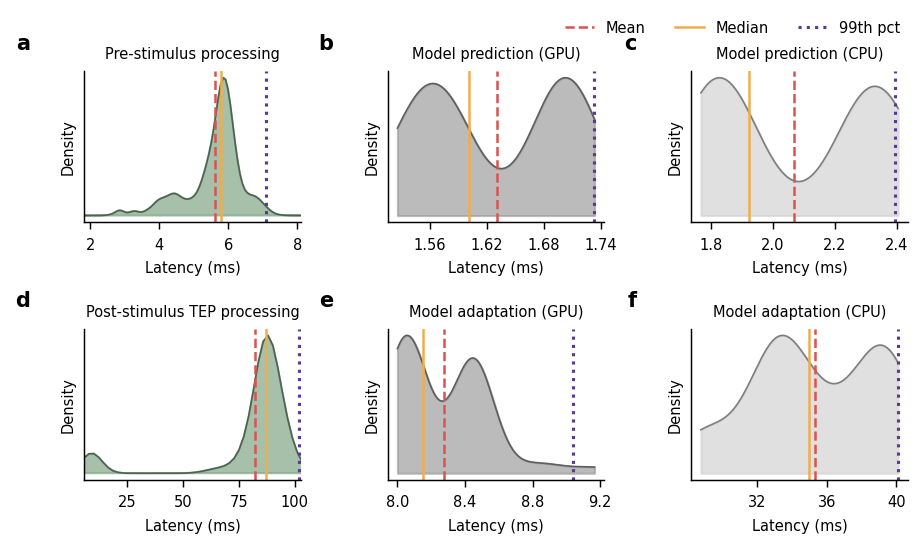

In [9]:
def create_and_save_figure(latency_data, output_dir):
    output_dir.mkdir(exist_ok=True)
    
    # 1. Apply consistent styling
    apply_matplotlib_settings()
    
    # 2. Create the figure and grid layout
    fig = plt.figure(figsize=(180 / 25.4, 90 / 25.4))
    gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.7, wspace=0.4)
    
    ax_pre_stim = fig.add_subplot(gs[0, 0])
    ax_pred_gpu = fig.add_subplot(gs[0, 1])
    ax_pred_cpu = fig.add_subplot(gs[0, 2])
    ax_tep = fig.add_subplot(gs[1, 0])
    ax_adapt_gpu = fig.add_subplot(gs[1, 1])
    ax_adapt_cpu = fig.add_subplot(gs[1, 2])

    # 3. Define the configuration for each plot panel
    plot_configs = [
        {'ax': ax_pre_stim,  'data_key': 'pre_stimulus',   'title': 'Pre-stimulus processing', 'color': '#80a687', 'set_xlim_to_p99': True},
        {'ax': ax_pred_gpu,  'data_key': 'pred_gpu',       'title': 'Model prediction (GPU)',   'color': '#9e9e9e', 'set_xlim_to_p99': False},
        {'ax': ax_pred_cpu,  'data_key': 'pred_cpu',       'title': 'Model prediction (CPU)',   'color': '#d3d3d3', 'set_xlim_to_p99': False},
        {'ax': ax_tep,       'data_key': 'tep_processing', 'title': 'Post-stimulus TEP processing', 'color': '#80a687', 'set_xlim_to_p99': True},
        {'ax': ax_adapt_gpu, 'data_key': 'adapt_gpu',      'title': 'Model adaptation (GPU)',   'color': '#9e9e9e', 'set_xlim_to_p99': False},
        {'ax': ax_adapt_cpu, 'data_key': 'adapt_cpu',      'title': 'Model adaptation (CPU)',   'color': '#d3d3d3', 'set_xlim_to_p99': False},
    ]

    # 4. Generate each plot
    logging.info("--- Generating Plots and Statistics ---")
    for config in plot_configs:
        plot_latency_histogram(
            ax=config['ax'],
            data=latency_data.get(config['data_key']), # Use .get() for safety
            title=config['title'],
            base_color=config['color'],
            set_xlim_to_p99=config['set_xlim_to_p99']
        )

    # 5. Add panel labels and legend
    axes = [ax_pre_stim, ax_pred_gpu, ax_pred_cpu, ax_tep, ax_adapt_gpu, ax_adapt_cpu]
    for ax, label in zip(axes, ['a', 'b', 'c', 'd', 'e', 'f']):
        ax.text(-0.25, 1.25, label, transform=ax.transAxes, fontsize=10, fontweight='bold', va='top', ha='right')
        
    legend_ax = next((ax for ax in axes if len(ax.get_lines()) > 0), axes[0])
    handles, labels = legend_ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', ncol=3, bbox_to_anchor=(0.905, 1.0))

    # 6. Save the final figure
    output_filename = output_dir / "processing_times_multi_panel_reproduced.pdf"
    plt.savefig(output_filename, bbox_inches='tight')
    logging.info(f"\n✅ Multi-panel figure saved successfully to {output_filename}")
    plt.show()

# --- Execute the plotting pipeline ---
if latency_data:
    create_and_save_figure(latency_data, Path("./latency_figure_final"))
else:
    logging.error("Figure creation skipped due to data loading failure.")